In [82]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pandas as pd
from shapely import wkt
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from matplotlib.patches import Polygon, Patch


In [2]:
# read a polygon in the below format
def read_polygon(filename):
    ''' input file format:
    segment {x1} {y1} {x2} {y2} (optionally)    
    {x1}  {y1}
    {x2}  {y2}
     ...
    {xn}  {yn}
    .... '''
    polygon = list()
    segment = None
    with open(filename, 'r') as f: # open in read-only mode
        lines = f.readlines()
        start_idx = 0
        first_line = lines[0].split()
        if first_line[0] == "segment":
            segment = [ [float(first_line[1]), float(first_line[2])], [float(first_line[3]), float(first_line[4])] ]
            start_idx = 1
        for line in lines[start_idx:]:
            if len(line.split()) != 2:
                break
            x = line.split()[0]
            y = line.split()[1]
            polygon.append((float(x), float(y)))
    # polygon.append(polygon[0]) # to "close" the polygon line
    return polygon, segment

# # Read a grid of single polygon in each cell
# # setting cell type to None
# def read_simple_grid(filename):
#     ''' input file format:
#     {x1}  {y1}
#     {x2}  {y2}
#      ...
#     {xn}  {yn}
#     poly {i} {j}
#     {x1'}  {y1'}
#     {x2'}  {y2'}
#      ...
#     {xn'}  {yn'}
#     poly {i} {j}
#     cell 
#     .... '''
#     polygon = []
#     grid = {}
#     i=j=0
#     with open(filename, 'r') as f: 
#         lines = f.readlines()
#         no_of_lines = len(lines)
#         line_idx = 0
#         while (line_idx < no_of_lines):
#             line = lines[line_idx]
#             splited_lines = line.split()
#             if len(splited_lines) == 3:
#                 i = int(line.split()[1])
#                 j = int(line.split()[2])
#                 grid[(i,j)] = {"polygon": polygon, "cell_type": None}
#                 polygon = []
#             elif len(splited_lines) == 2:
#                 x = float(line.split()[0])
#                 y = float(line.split()[1])
#                 polygon.append((x, y))
#             else:
#                 print(line)
#                 print('Error')
#                 break

#             line_idx += 1
            
#     return grid

# Read a grid of multi/single polygon in each cell 
# without cell types
def read_grid_without_cell_types(filename):
    ''' input file format:
    {x1}  {y1}
    {x2}  {y2}
     ...
    {xn}  {yn}
    poly 
    {x1'}  {y1'}
    {x2'}  {y2'}
     ...
    {xn'}  {yn'}
    poly 
    cell {i} {j}
    .... '''
    polygons = []
    polygon = []
    grid = {}
    i=j=0
    with open(filename, 'r') as f: # open in read-only mode
        lines = f.readlines()
        no_of_lines = len(lines)
        line_idx = 0
        while (line_idx < no_of_lines):
            line = lines[line_idx]
            splited_lines = line.split()
            
            if len(splited_lines) == 3:
                i = int(line.split()[1])
                j = int(line.split()[2])
    
                grid[(i,j)] = {"vertices_vectors": polygons, "cell_type": None}
                polygons = []
                polygon = []
            elif len(splited_lines) == 2:
                x = float(line.split()[0])
                y = float(line.split()[1])
                polygon.append((x, y))
            elif len(splited_lines) == 1:
                polygons.append(polygon)
                polygon = []
            else:
                print(line)
                print('Error')
                break

            line_idx += 1
            
    return grid

# Read a grid of multi/single polygon in each cell 
# including cell types
def read_grid(filename):
    ''' input file format:
    {x1}  {y1}
    {x2}  {y2}
     ...
    {xn}  {yn}
    poly 
    {x1'}  {y1'}
    {x2'}  {y2'}
     ...
    {xn'}  {yn'}
    poly 
    cell {i} {j}
    {cell_type}
    .... '''
    polygon = []
    polygons = []
    grid = {}
    i=j=0
    with open(filename, 'r') as f: # open in read-only mode
        lines = f.readlines()
        no_of_lines = len(lines)
        line_idx = 0
        while (line_idx < no_of_lines):
            line = lines[line_idx]
            splited_lines = line.split()

            if len(splited_lines) == 3:
                i = int(line.split()[1])
                j = int(line.split()[2])

                line_idx += 1
                cell_type = lines[line_idx].split()[0]
                grid[(i,j)] = {"polygons": polygons, "cell_type": cell_type}
                polygons = []
                polygon = []
            elif len(splited_lines) == 2:
                x = float(line.split()[0])
                y = float(line.split()[1])
                polygon.append((x, y))
            elif len(splited_lines) == 1:
                polygons.append(polygon)
                polygon = []
            else:
                print(line)
                print('Error')
                break

            line_idx += 1
            
    return grid

# plot a polygon and a segment if provided
def plot_polygon(polygon, segment=None, figsize=(6, 4)):
    plt.figure(figsize=figsize)
    plt.rcParams["figure.autolayout"] = True
    plt.grid()
    
    x, y = zip(*polygon)
    num_points = len(polygon)
    colors = plt.cm.viridis(np.linspace(0, 1, num_points))

    for i in range(num_points - 1):
        plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], marker='o', color=colors[0])
    
    if segment:
        plt.plot([segment[0][0], segment[1][0]], [segment[0][1], segment[1][1]], marker='.', color='red', linewidth=5)
    
    plt.show()

# def plot_grid(grid, cell_type_to_color):
#     fig, ax = plt.subplots(figsize=(12, 12))  # Adjust width and height as needed

#     # Plot each cell
#     for (i, j), vertices_cell_type in grid.items():
#         vertices = vertices_cell_type['polygon']
#         cell_type = vertices_cell_type['cell_type']
#         # print(i, j, len(vertices), cell_type)
#         # Extract vertices for the polygon
#         if vertices:
#             x, y = zip(*vertices)
#             # Determine color by coordinate sum
#             color = cell_type_to_color[cell_type]
#             ax.fill(x, y, color, edgecolor='black', alpha=0.3)
#             ax.scatter(x, y, color='black', )


#     ax.set_aspect('equal')
#     # ax.grid(True, which='both', linestyle='--', linewidth=0.5)
#     plt.show()    
    
# plot a grid of polygons in the cells 
# with color in each cell depending on the type
# of the cell for which we use the map cell_type_to_color
def plot_grid(grid, cell_type_to_color, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)  # Adjust width and height as needed

    # Plot each cell
    for (i, j), vertices_vectors_cell_type in grid.items():
        vertices_vectors = vertices_vectors_cell_type['polygons']
        cell_type = vertices_vectors_cell_type['cell_type']
        if vertices_vectors:
            # Determine color by coordinate sum
            # color = 'blue' if (i + j) % 2 == 0 else 'red'
            color = cell_type_to_color[cell_type]
            # color = 'blue' if i  % 2 == 0 else 'red'
            for vertices in vertices_vectors:
                x, y = zip(*vertices)
                ax.fill(x, y, color, edgecolor='black', alpha=0.3)
                # Plot the vertices as points
                ax.scatter(x, y, color='black', s=10)

    # ax.set_aspect('equal')
    plt.axis('off')
    # ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# # plot a grid of polygons in the cells 
# # with different color between neighboors cells
# def plot_simple_grid(grid):
#     fig, ax = plt.subplots(figsize=(10, 8))  # Adjust width and height as needed

#     # Plot each cell
#     for (i, j), vertices_cell_type in grid.items():
#         vertices = vertices_cell_type['polygon']
#         if vertices:
#             x, y = zip(*vertices)
#             # Determine color by coordinate sum
#             color = 'blue' if (i + j) % 2 == 0 else 'red'
#             ax.fill(x, y, color, edgecolor='black', alpha=0.3)
#             # Plot the vertices as points
#             ax.scatter(x, y, color='black')

#     ax.set_aspect('equal')
#     # ax.grid(True, which='both', linestyle='--', linewidth=0.5)
#     plt.show()

# plot a grid of MULTIpolygons in the cells 
# with different color between neighboors cells
def plot_grid_without_cell_type(grid, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)  # Adjust width and height as needed

    # Plot each cell
    for (i, j), vertices_vectors_cell_type in grid.items():
        vertices_vectors = vertices_vectors_cell_type['vertices_vectors']
        # Extract vertices for the polygon
        if vertices_vectors:
            
            # Determine color by coordinate sum
            color = 'blue' if (i + j) % 2 == 0 else 'red'
            # color = 'blue' if i  % 2 == 0 else 'red'
            for vertices in vertices_vectors:
                x, y = zip(*vertices)
                ax.fill(x, y, color, edgecolor='black', alpha=0.3)
                # Plot the vertices as points
                ax.scatter(x, y, color='black')

    # ax.set_aspect('equal')
    # ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()


def find_files(directory="./", prefix="grid"):
    files = []
    pattern = os.path.join(directory, f"{prefix}*")
    for filename in glob.glob(pattern):
        files.append(filename)

    return files

def polygon_area(vertices):
    n = len(vertices)
    area = 0.0
    
    for i in range(n-1):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]
        print(f"({x1}, {y1}) - ({x2}, {y2}): {x1 * y2 - y1 * x2}")
        area += x1 * y2 - y1 * x2
    
    return abs(area) / 2.0

def cross_product(p1, p2, p3):
    return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

def is_polygon_cw(vertices):
    sum = 0
    n = len(vertices)
    for i in range(n):
        p1 = vertices[i]
        p2 = vertices[(i + 1) % n]
        sum += (p2[0] - p1[0]) * (p2[1] + p1[1])
    return sum > 0


In [30]:
# def is_clockwise(polygon):
#     # Extract the exterior coordinates of the polygon
#     coords = list(polygon.exterior.coords)
#     # Calculate the signed area
#     area = 0.0
#     for i in range(len(coords) - 1):
#         x1, y1 = coords[i]
#         x2, y2 = coords[i + 1]
#         area += (x2 - x1) * (y2 + y1)
#     # Return True if the polygon is clockwise, False if counterclockwise
#     return area > 0
# # Function to check if a geometry is a polygon without holes
# def is_simple_polygon(geom):
#     if isinstance(geom, Polygon):
#         return not geom.interiors
#     elif isinstance(geom, MultiPolygon):
#         return all(not poly.interiors for poly in geom)
#     return False

# in_file_path = "error_poly.txt"
# data = pd.read_csv(in_file_path, names=['WKT'])
# geo_gdf = gpd.GeoDataFrame(data, geometry=data['WKT'].apply(wkt.loads))
# # Filter polygons and multipolygons without holes
# geo_gdf['is_simple'] = geo_gdf['geometry'].apply(is_simple_polygon)
# geo_gdf['is_valid'] = geo_gdf['geometry'].apply(lambda geom: geom.is_valid)

# # Apply the function to each geometry and add a new column 'is_cw'
# geo_gdf['is_cw'] = geo_gdf['geometry'].apply(is_clockwise)
# display(geo_gdf.head())

,WKT,geometry,is_simple,is_cw,is_valid
0,"POLYGON ((-95.870899 46.345009,-95.870807 46.3...","POLYGON ((-95.87090 46.34501, -95.87081 46.345...",True,True,True


In [4]:
# fig, ax = plt.subplots(figsize=(12, 8))  # Larger figure size
# geo_gdf.plot(ax=ax, color='blue', edgecolor='black')

# plt.title('Polygon Visualization')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()

In [130]:
# cell_type_to_color = {
#     "FULL": "#FF0000",
#     "STRONG": "#FFDD44",
#     "WEAK": "#ADD8E6",
#     # "NULL": "red"
# }

cell_type_to_color = {
    "FULL": "red",
    "STRONG": "#FF8C00",
    "WEAK": "yellow",
    # "NULL": "red"
}

In [56]:
def read_poly_grid(filename):
    ''' input file format:
    {xmin_idx} {ymin_idx} {xmax_idx} {ymax_idx}
    {xmin} {ymin} {step}
    {x1}  {y1}
    {x2}  {y2}
     ...
    {xn}  {yn}
    .... '''
    poly = []
    grid_cell_types = []
    with open(filename, 'r') as f: # open in read-only mode
        lines = f.readlines()

        first_line_splited = lines[0].split()
        xmin_idx, ymin_idx, xmax_idx, ymax_idx = int(first_line_splited[0]), int(first_line_splited[1]), int(first_line_splited[2]), int(first_line_splited[3])
        mbr_idxs = {
            "xmin_idx": xmin_idx, 
            "ymin_idx": ymin_idx, 
            "xmax_idx": xmax_idx, 
            "ymax_idx": ymax_idx
        }

        sec_line_splited = lines[1].split()
        grid_xmin, grid_ymin, grid_xmax, grid_ymax, step = float(sec_line_splited[0]), float(sec_line_splited[1]), float(sec_line_splited[2]), float(sec_line_splited[3]), float(sec_line_splited[4])  
        grid_info = {
            'xmin': grid_xmin,
            'ymin': grid_ymin,
            'xmax': grid_xmax,
            'ymax': grid_ymax,
            'step': step
        }
        for line in lines[2:]:
            split_line = line.split()
            if len(split_line) == 3:
                i,j,cell_type = int(split_line[0]), int(split_line[1]), split_line[2]
                grid_cell_types.append((i,j,cell_type))
            if len(split_line) == 2:
                x = split_line[0]
                y = split_line[1]
                poly.append((float(x), float(y)))
    
    # x_s = sorted(set(p[0] for p in mbr_grid))
    # y_s = sorted(set(p[1] for p in mbr_grid))
    return mbr_idxs, grid_info, grid_cell_types, poly

In [117]:
def read_create_poly_grid(f_name):
    mbr_idxs, grid_info, grid_cell_types, poly = read_poly_grid(f_name)

    if mbr_idxs['xmin_idx'] > 0:
        xmin_idx = mbr_idxs['xmin_idx'] - 1 
    else:
        xmin_idx = mbr_idxs['xmin_idx']

    if mbr_idxs['ymin_idx'] > 0:
        ymin_idx = mbr_idxs['ymin_idx'] - 1 
    else:
        ymin_idx = mbr_idxs['ymin_idx'] 

    mbr_xmax = grid_info['xmin'] + mbr_idxs['xmax_idx'] * grid_info['step']
    mbr_ymax = grid_info['ymin'] + mbr_idxs['ymax_idx'] * grid_info['step']

    if mbr_xmax < grid_info['xmax']:
        xmax_idx = mbr_idxs['xmax_idx'] + 1 
    else:
        xmax_idx = mbr_idxs['xmax_idx']

    if mbr_ymax < grid_info['ymax']:
        ymax_idx = mbr_idxs['ymax_idx'] + 1 
    else:
        ymax_idx = mbr_idxs['ymax_idx']

    mbr_idxs = {
        "xmin_idx": xmin_idx, 
        "ymin_idx": ymin_idx, 
        "xmax_idx": xmax_idx, 
        "ymax_idx": ymax_idx
    }

    cells_square_type = []
    for i, j, cell_type in grid_cell_types:
        p0 = (grid_info['xmin'] + i * grid_info['step'], grid_info['xmin'] + j * grid_info['step']) 
        p1 = (grid_info['xmin'] + i * grid_info['step'], grid_info['xmin'] + (j+1) * grid_info['step']) 
        p2 = (grid_info['xmin'] + (i+1) * grid_info['step'], grid_info['xmin'] + (j+1) * grid_info['step']) 
        p3 = (grid_info['xmin'] + (i+1) * grid_info['step'], grid_info['xmin'] + j * grid_info['step']) 
        square = [p0, p1, p2, p3, p0]
        cells_square_type.append({
            "square": square,
            "cell_type": cell_type
        })

    x_s = []
    for i in range(mbr_idxs['xmin_idx'], mbr_idxs['xmax_idx'] + 1):
        x = grid_info['xmin'] + i * grid_info['step']
        x_s.append(x)

    y_s = []
    for i in range(mbr_idxs['ymin_idx'], mbr_idxs['ymax_idx']):
        y = grid_info['ymin'] + i * grid_info['step']
        y_s.append(y)

    return mbr_idxs, grid_info, x_s, y_s, poly, cells_square_type

def plot_complete_grid(polygon, x_s, y_s, cells_square_type, cell_type_to_color, show_points=True, show_axis_numbers=True, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)  # Create the figure and axis
    
    # Create a meshgrid from x and y coordinates
    X, Y = np.meshgrid(x_s, y_s)
    
    # Plot the vertical grid lines
    for i in range(len(x_s)):
        ax.plot([x_s[i]]*len(y_s), y_s, color='black', linestyle='-', linewidth=0.5)  # Vertical lines

    # Plot the horizontal grid lines
    for j in range(len(y_s)):
        ax.plot(x_s, [y_s[j]]*len(x_s), color='black', linestyle='-', linewidth=0.5)  # Horizontal lines

    # Plot the polygon
    polygon_patch = Polygon(polygon, fill=None, edgecolor='blue', linewidth=1.5)
    ax.add_patch(polygon_patch)

    for square_cell_type in cells_square_type:
        square = square_cell_type['square']
        cell_type = square_cell_type['cell_type']
        color = cell_type_to_color.get(cell_type, 'gray')  # Default to gray if cell_type not in the dict
        x, y = zip(*square)
        ax.fill(x, y, color, edgecolor='black', alpha=0.3)
        # if show_points:
        #     ax.scatter(x, y, color='black', s=10)

    if show_points:
        # Plot points at the vertices of the polygon
        polygon_x, polygon_y = zip(*polygon)
        ax.plot(polygon_x, polygon_y, 'ro', color='black')

    # Set the aspect ratio to be equal
    ax.set_aspect('equal')

    if show_axis_numbers:
        # Set axis labels and ticks
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xticks(x_s)
        ax.set_yticks(y_s)
        plt.title('Complete Grid Plot with Polygon')
    else:
        # Hide axis labels and ticks
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        # Hide numerical labels on the x and y axes
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # Turn off the axis frame
        ax.axis('off')

    # Create legend
    legend_patches = [Patch(facecolor=color, edgecolor='black', label=cell_type) 
                      for cell_type, color in cell_type_to_color.items()]
    
    # Position the legend outside the plot
    ax.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5), title='Cell Types')

    # Adjust layout to make space for the legend
    fig.tight_layout()
    fig.subplots_adjust(right=0.75)  # Adjust to make space on the right for the legend

    # Set grid lines
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Show plot
    plt.show()

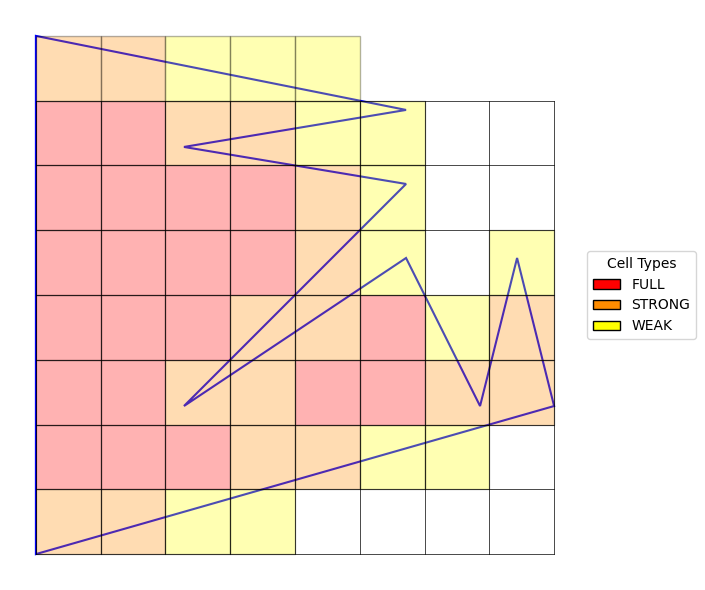

In [131]:
mbr_idxs, grid_info, x_s, y_s, poly, cells_square_type = read_create_poly_grid("poly_grid.txt")
plot_complete_grid(poly, x_s, y_s, cells_square_type, cell_type_to_color, False, False)

In [28]:
def read_mbr_grid(filename):
    ''' input file format:
    {x1}  {y1}
    {x2}  {y2}
     ...
    {xn}  {yn}
    .... '''
    mbr_grid = list()
    with open(filename, 'r') as f: # open in read-only mode
        lines = f.readlines()
        start_idx = 0
        for line in lines[start_idx:]:
            if len(line.split()) != 2:
                break
            x = line.split()[0]
            y = line.split()[1]
            mbr_grid.append((float(x), float(y)))
    
    x_s = sorted(set(p[0] for p in mbr_grid))
    y_s = sorted(set(p[1] for p in mbr_grid))
    return mbr_grid, x_s, y_s

def plot_mbr_grid(x, y):
    """
    Plots a square grid based on the given x and y coordinates without plotting individual points.
    
    Parameters:
    x (numpy.ndarray): A 1D array of x coordinates.
    y (numpy.ndarray): A 1D array of y coordinates.
    """
    # Create a meshgrid from x and y coordinates
    X, Y = np.meshgrid(x, y)
    
    # Plot the vertical grid lines
    for i in range(len(x)):
        plt.plot([x[i]]*len(y), y, color='black')  # Vertical lines

    # Plot the horizontal grid lines
    for j in range(len(y)):
        plt.plot(x, [y[j]]*len(x), color='black')  # Horizontal lines
    
    plt.grid(False)  # Turn off the default grid
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Grid Plot')
    plt.show()

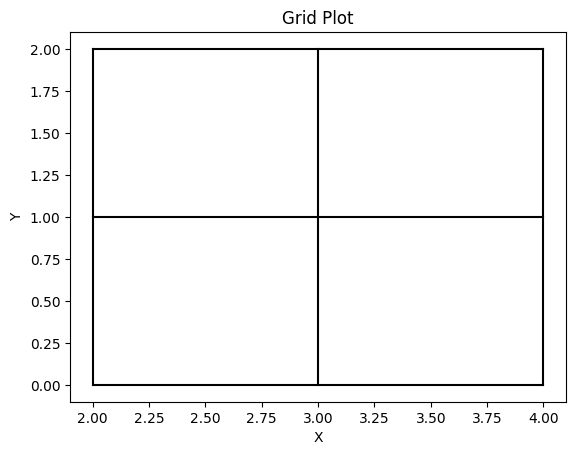

In [5]:
mbr_grid, x_s, y_s = read_mbr_grid("mbr_grid.txt")
plot_mbr_grid(x_s, y_s)

In [6]:
def plot_complete_grid(grid, cell_type_to_color, x_s, y_s, show_points=True, show_axis_numbers=True, figsize=(8,6)):
    fig, ax = plt.subplots(figsize=figsize)  # Create the figure and axis
    
    # Create a meshgrid from x and y coordinates
    X, Y = np.meshgrid(x_s, y_s)
    
    # Plot the vertical grid lines
    for i in range(len(x_s)):
        ax.plot([x_s[i]]*len(y_s), y_s, color='black', linestyle='-', linewidth=0.5)  # Vertical lines

    # Plot the horizontal grid lines
    for j in range(len(y_s)):
        ax.plot(x_s, [y_s[j]]*len(x_s), color='black', linestyle='-', linewidth=0.5)  # Horizontal lines

    # Plot each cell
    for (i, j), vertices_vectors_cell_type in grid.items():
        vertices_vectors = vertices_vectors_cell_type['polygons']
        cell_type = vertices_vectors_cell_type['cell_type']
        if vertices_vectors:
            color = cell_type_to_color.get(cell_type, 'red')  # Default to gray if cell_type not in the dict
            for vertices in vertices_vectors:
                x, y = zip(*vertices)
                ax.fill(x, y, color, edgecolor='black', alpha=0.3)
                if show_points:
                    ax.scatter(x, y, color='black', s=10)

    # Set the aspect ratio to be equal
    ax.set_aspect('equal')

    if show_axis_numbers:
        # Set axis labels and ticks
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xticks(x_s)
        ax.set_yticks(y_s)
        # Show numerical labels on the x and y axes
        ax.set_xticklabels(x_s)
        ax.set_yticklabels(y_s)
    else:
        # Hide axis labels and ticks
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        # Hide numerical labels on the x and y axes
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # Turn off the axis frame
        ax.axis('off')

    # Set grid lines
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Show plot
    plt.title('Complete Grid Plot')
    plt.show()

In [9]:
grid

{(0, 1): {'polygons': [], 'cell_type': 'WEAK'},
 (0, 2): {'polygons': [], 'cell_type': 'WEAK'},
 (0, 3): {'polygons': [], 'cell_type': 'WEAK'},
 (1, 1): {'polygons': [], 'cell_type': 'WEAK'},
 (1, 2): {'polygons': [], 'cell_type': 'WEAK'},
 (1, 3): {'polygons': [], 'cell_type': 'WEAK'},
 (2, 1): {'polygons': [], 'cell_type': 'WEAK'},
 (2, 2): {'polygons': [], 'cell_type': 'WEAK'},
 (2, 3): {'polygons': [], 'cell_type': 'WEAK'}}

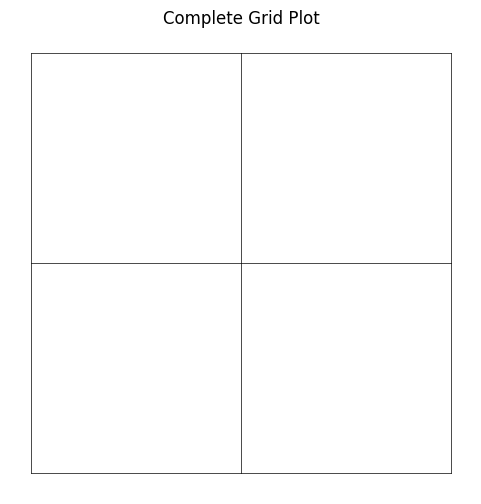

In [8]:
plot_complete_grid(grid, cell_type_to_color, x_s, y_s, show_points=False, show_axis_numbers=False)

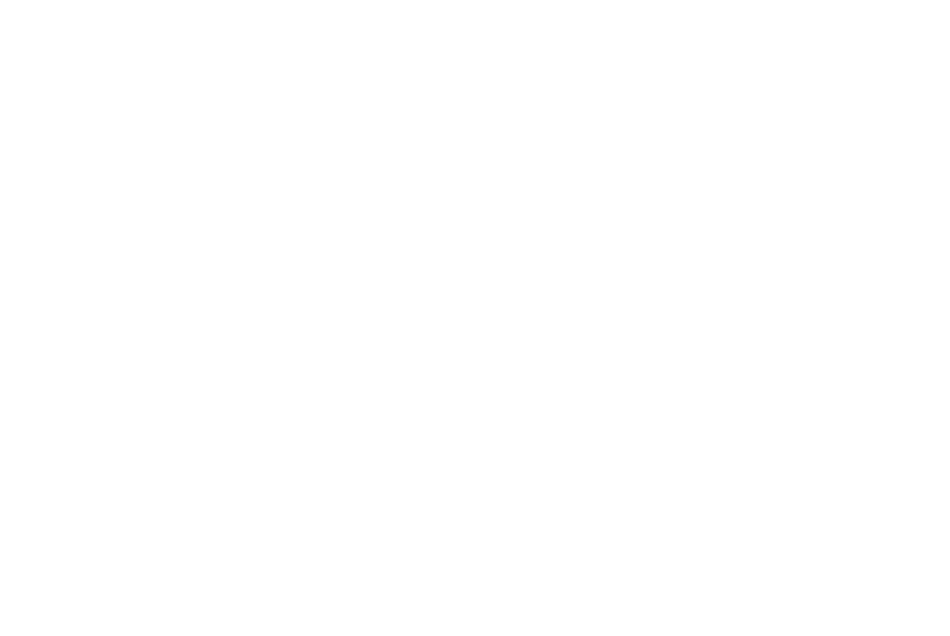

In [7]:
error = "error.txt"
output = "output.txt"
grid_f_name = "grid.txt"
test = "../../build/wrong_clip.txt"
grid = read_grid(grid_f_name)
plot_grid(grid, cell_type_to_color, (12,8))

In [1]:
error = "error.txt"
output = "output.txt"
grid_f_name = "grid.txt"
test = "../../build/wrong_clip.txt"
grid = read_grid(grid_f_name)
plot_grid(grid, cell_type_to_color, (12,8))

NameError: name 'read_grid' is not defined

In [5]:
files = find_files()

In [5]:
# for file in files:
#     grid = read_grid(file)
#     plot_grid(grid)

In [7]:
# simple_grid2 = read_simple_grid("test2.txt")
# plot_simple_grid(simple_grid2)

In [10]:
# grid_area = 0
# for vertices in grid.values():
#     if vertices:
#         print(vertices)
#         print(polygon_area(vertices))
#         grid_area+=polygon_area(vertices)
# grid_area

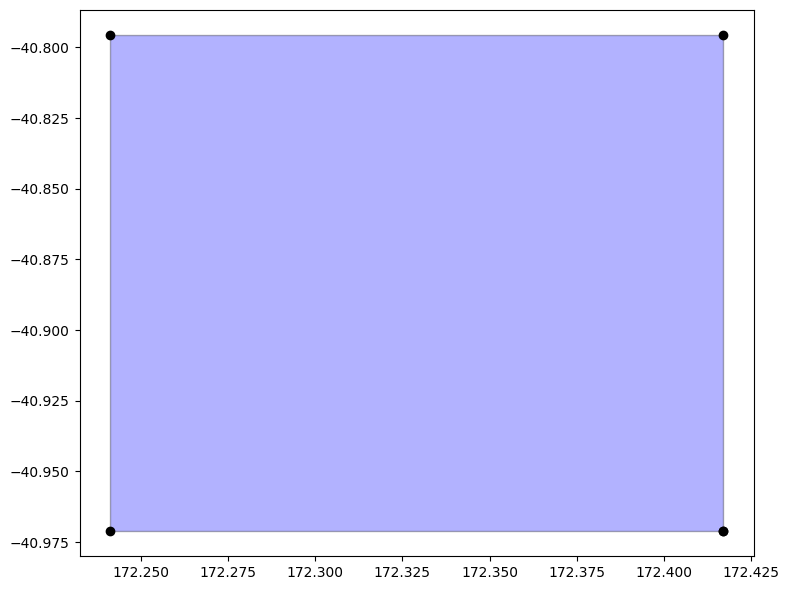

In [35]:
col_error = read_vectors_grid(test)
plot_point_vectors(col_error)

In [7]:
inter_grid = read_vectors_grid("inter_result.txt")
plot_point_vectors(inter_grid)

FileNotFoundError: [Errno 2] No such file or directory: 'inter_result.txt'

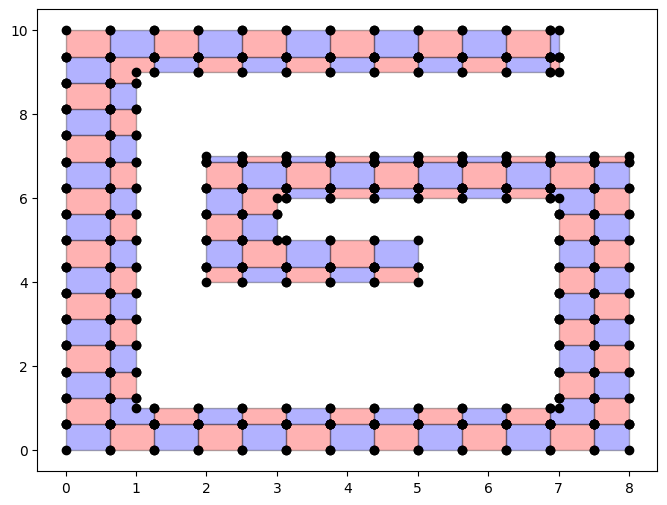

In [31]:
grid = read_vectors_grid("result.txt")
plot_point_vectors(grid)

In [36]:
poly, segment = read_polygon("error.txt")
plot_polygon(poly, segment, figsize=(6,4))

grid = read_vectors_grid("inter_result.txt")
plot_point_vectors(grid, figsize=(6,4))

FileNotFoundError: [Errno 2] No such file or directory: 'error.txt'

In [30]:
print(segment)

[[8.75, 8.75], [9.0625, 8.75]]


In [34]:
segment

[[-95.870119, 46.343819], [-95.870119, 46.343819]]

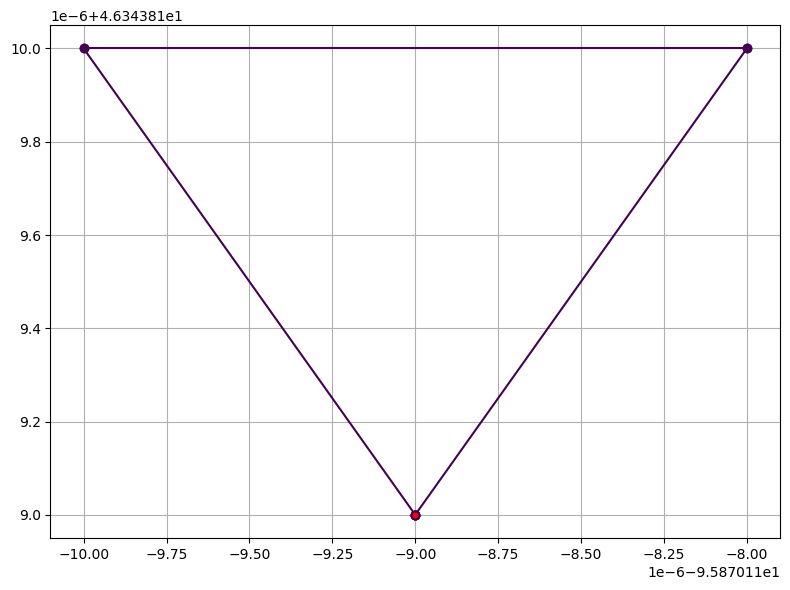

In [33]:
poly, segment = read_polygon("weiler_error.txt")
plot_polygon(poly, segment, figsize=(8,6))

# grid = read_vectors_grid("result.txt")
# plot_point_vectors(grid)

In [8]:
if is_polygon_cw(poly):
    print("The polygon is in clockwise order.")
else:
    print("The polygon is in counterclockwise order.")

The polygon is in counterclockwise order.


In [12]:
def is_clockwise(coords):
    # Extract the exterior coordinates of the polygon
    # Calculate the signed area
    area = 0.0
    for i in range(len(coords) - 1):
        x1, y1 = coords[i]
        x2, y2 = coords[i + 1]
        area += (x2 - x1) * (y2 + y1)
    # Return True if the polygon is clockwise, False if counterclockwise
    return area > 0

# Apply the function to each geometry and add a new column 'is_cw'
is_clockwise(poly)

False

In [13]:
len(poly)

71

([(2.0, 9.0), (7.0, 8.0), (4.0, 7.5), (7.0, 7.0), (2.0, 7.0), (2.0, 9.0)], None)


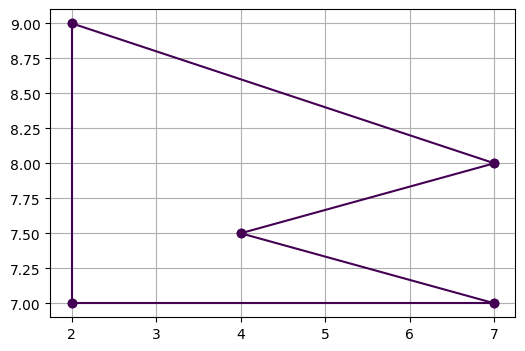

In [6]:
poly = read_polygon("polygon.txt")
print(poly)
plot_polygon(poly[0], figsize=(6,4))

([(2.0, 9.0), (7.0, 8.0), (4.0, 7.5), (7.0, 7.0), (4.0, 4.0), (7.0, 6.0), (8.0, 4.0), (8.5, 6.0), (9.0, 4.0), (2.0, 2.0), (2.0, 9.0)], None)


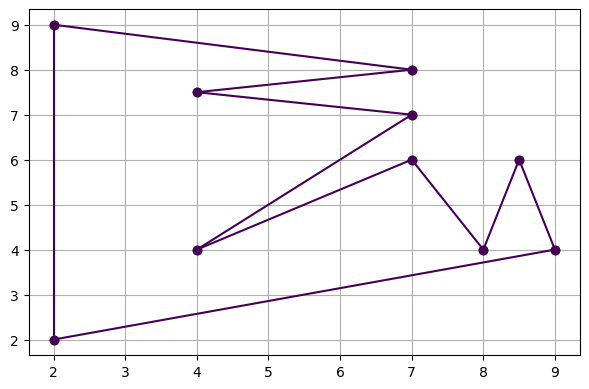

In [29]:
poly = read_polygon("../../build/left_poly.txt")
print(poly)
plot_polygon(poly[0], figsize=(6,4))

In [19]:
len(poly[0])

71

In [20]:
is_clockwise(poly[0])

False